In [1]:
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
import jax

import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random

try:
  import flax
except ModuleNotFoundError:
  !pip install --quiet flax
  import flax

try:
  import optax
except ModuleNotFoundError:
  !pip install --quiet optax
  import optax

try:
  import diffrax
except ModuleNotFoundError:
  !pip install --quiet diffrax
  import diffrax

from flax import linen as nn
from flax.training import train_state

from tqdm import trange
from functools import partial

/ssd003/home/kirill/venvs/jax-env/lib/python3.9/site-packages/flax/core/frozen_dict.py:169: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(


In [7]:
from typing import NamedTuple, Any
import scanpy as sc

adata = sc.read_h5ad("wl-mechanics/assets/op_train_multi_targets_0.h5ad")
print(adata)
# sc.pl.scatter(adata, basis="phate", color="sample_labels")

AnnData object with n_obs × n_vars = 33701 × 23418
    obs: 'day', 'donor', 'cell_type', 'technology'
    uns: 'pca'
    obsm: 'X_pca'
    varm: 'PCs'


In [9]:
sc.pp.highly_variable_genes(adata, n_top_genes=1000)
data = adata.X[:, adata.var["highly_variable"]].toarray()

In [10]:
data.shape

(33701, 1000)

In [22]:
adata.obs["day"] = adata.obs["sample_labels"].cat.codes

In [23]:
times = adata.obs["day"].unique()
coords = adata.obsm["X_pca"][:,:5]
coords = (coords - coords.mean(axis=0)) / coords.std(axis=0)
adata.obsm["X_pca_standardized"] = coords
X = [
    adata.obsm["X_pca_standardized"][adata.obs["day"] == t]
    for t in times
]
# X = X[:3]

BS = 512

@jax.jit
def get_batch(key):
    keys = jax.random.split(key,len(X))
    batch = []
    for i in range(len(X)):
        batch.append(random.choice(keys[i], X[i], (BS,), replace=False))
    return jnp.concatenate(batch, -1)

seed = 0
np.random.seed(seed)
key = random.PRNGKey(seed)
print(get_batch(key).shape)

(512, 25)


In [48]:
seed = 0
np.random.seed(seed)
key = random.PRNGKey(seed)

class Smodel(nn.Module):
  num_hid : int

  @nn.compact
  def __call__(self, t, x):
    h = jnp.hstack([t,x])
    h = nn.Dense(self.num_hid)(h)
    h = nn.relu(h)
    h = nn.Dense(self.num_hid)(h)
    h = nn.swish(h)
    h = nn.Dense(self.num_hid)(h)
    h = nn.swish(h)
    h = nn.Dense(1)(h)
    return h

class Qmodel(nn.Module):
  num_hid : int
  n_dims : int

  @nn.compact
  def __call__(self, t, x, u):
    n_intervals = len(X)-1
    t_1 = jnp.sum(jnp.arange(n_intervals)[None,:] < t*n_intervals, 1, keepdims=True).astype(int)
    t_1 = jnp.fmax(t_1, jnp.ones_like(t_1).astype(int))
    t_0 = t_1 - 1
    input_x = x.reshape(-1, n_intervals+1, self.n_dims)
    x_0 = input_x[jnp.arange(len(input_x)), t_0.ravel(), :]
    x_1 = input_x[jnp.arange(len(input_x)), t_1.ravel(), :]
    indicator = jax.nn.one_hot(t_0.ravel(), n_intervals)
    h = jnp.hstack([t, jnp.concatenate([x_0, x_1], 1)])
    # h = jnp.hstack([t, x, indicator])
    h = nn.Dense(self.num_hid)(h)
    h = nn.relu(h)
    h = nn.Dense(self.num_hid)(h)
    h = nn.swish(h)
    h = nn.Dense(self.num_hid)(h)
    h = nn.swish(h)
    h = nn.Dense(self.n_dims)(h)
    t_0, t_1 = t_0/n_intervals, t_1/n_intervals
    out = (t_1-t)/(t_1-t_0)*x_0 + (t-t_0)/(t_1-t_0)*x_1
    out += jnp.sqrt(1.0 - ((t-t_0)/(t_1-t_0))**2 - ((t_1-t)/(t_1-t_0))**2)*h
    return out

In [49]:
def sample_t(u0, n, t0=0.0, t1=1.0):
  u = (u0 + math.sqrt(2)*jnp.arange(n + 1)) % 1
  u = u.reshape([-1,1])
  return u[:-1]*(t1-t0) + t0, u[-1]

In [50]:
n_dims = X[0].shape[1]
u_dim = 10

s = Smodel(num_hid=512)
q = Qmodel(num_hid=512, n_dims=n_dims)

key, *init_keys = random.split(key, 4)
init_batch = get_batch(init_keys[0])
state_s = train_state.TrainState.create(apply_fn=s.apply,
                                        params=s.init(init_keys[1], np.ones([BS,1]), init_batch[:,:n_dims]),
                                        tx=optax.adam(learning_rate=2e-4))

state_q = train_state.TrainState.create(apply_fn=q.apply,
                                        params=q.init(init_keys[2], np.ones([BS,1]), init_batch, np.ones([BS,u_dim])),
                                        tx=optax.adam(learning_rate=2e-4))

# derivatives of the model that we need to define the loss
def V(t, x, p):
  dsdtdx_fn = jax.grad(lambda t, x, p: state_s.apply_fn(p,t,x).sum(), argnums=[0,1])
  dsdt, dsdx = dsdtdx_fn(t, x, p)
  return dsdt + 0.5*(dsdx**2).sum(1, keepdims=True)
dVdx_fn = jax.grad(lambda t, x, p: V(t,x,p).sum(), argnums=1)
# and to apply the model
dsdx_fn = jax.jit(jax.grad(lambda t, x, p: state_s.apply_fn(p,t,x).sum(), argnums=1))

In [51]:
t = np.linspace(0.0, 1.0, 100)
x_t = np.zeros([BS,len(t),n_dims])
key, iter_key = random.split(key)
for i in range(len(t)):
  u = random.uniform(random.fold_in(iter_key, i), shape=(BS, u_dim))
  x_t[:,i,:] = state_q.apply_fn(state_q.params, t[i]*jnp.ones([BS,1]), init_batch, u)

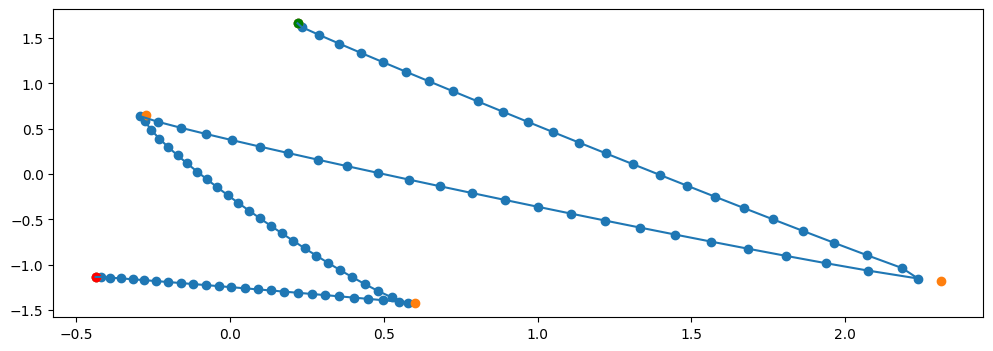

In [52]:
i=0
plt.plot(x_t[i,:,0], x_t[i,:,1])
plt.scatter(x_t[i,:,0], x_t[i,:,1])
plt.scatter(init_batch.reshape(-1,len(X),n_dims)[i,:,0], init_batch.reshape(-1,len(X),n_dims)[i,:,1])
plt.scatter(init_batch.reshape(-1,len(X),n_dims)[i,0,0], init_batch.reshape(-1,len(X),n_dims)[i,0,1], c='red')
plt.scatter(init_batch.reshape(-1,len(X),n_dims)[i,-1,0], init_batch.reshape(-1,len(X),n_dims)[i,-1,1], c='green')

In [53]:
def loss_fn(key, state_s, state_q, params_s, params_q, x_batch, u0):
  t_0, t_1 = jnp.zeros([BS, 1]), jnp.ones([BS, 1])
  t, u0 = sample_t(u0, BS)
  x_0, x_1 = x_batch[:,:n_dims], x_batch[:,-n_dims:]
  u = random.uniform(key, shape=(BS, u_dim))
  # u = jnp.ones_like(u)
  x_t = state_q.apply_fn(params_q, t, x_batch, u)
  update = jax.lax.stop_gradient(dVdx_fn(t, x_t, params_s))
  t_grid = jnp.arange(len(X))[None, :]/(len(X)-1)
  mask = (t >= t_grid[:,:-1])*(t <= t_grid[:,1:])
  t_mult = 1e-1*(jnp.sqrt(1.0 - ((t-t_grid[:,:-1])*(len(X)-1))**2*mask -\
     ((t_grid[:,1:]-t)*(len(X)-1))**2*mask)*mask).sum(1, keepdims=True)
  x_t += t_mult*update
  x_t = jax.lax.stop_gradient(x_t)

  loss = state_s.apply_fn(params_s, t_0, x_0) - state_s.apply_fn(params_s, t_1, x_1)
  loss += V(t, x_t, params_s)
  loss -= V(t, state_q.apply_fn(params_q, t, x_batch, u), jax.lax.stop_gradient(params_s))
  return loss.mean(), (jnp.sqrt((update**2).sum(1)).mean(), u0)

@jax.jit
def train_step(key, state_s, state_q, x_batch, u0):
  grad_fn = jax.value_and_grad(loss_fn, argnums=[3,4], has_aux=True)
  (loss, (gradV, u0)), grads = grad_fn(key, state_s, state_q, state_s.params, state_q.params, x_batch, u0)
  state_s = state_s.apply_gradients(grads=grads[0])
  state_q = state_q.apply_gradients(grads=grads[1])
  return state_s, state_q, loss, gradV, u0

key, init_key = random.split(key)
_, _, _, _, _ = train_step(init_key, state_s, state_q, init_batch, 0.5)

In [54]:
num_iterations = 100_000
u0 = 0.5

loss_plot = np.zeros(num_iterations)
gradV_plot = np.zeros(num_iterations)
for iter in trange(num_iterations):
  key, *loc_key = random.split(key, 3)
  state_s, state_q, loss, gradV, u0 = train_step(loc_key[0], state_s, state_q, get_batch(loc_key[1]), u0)
  loss_plot[iter] = loss
  gradV_plot[iter] = gradV

 15%|█▌        | 15200/100000 [01:31<08:28, 166.71it/s]

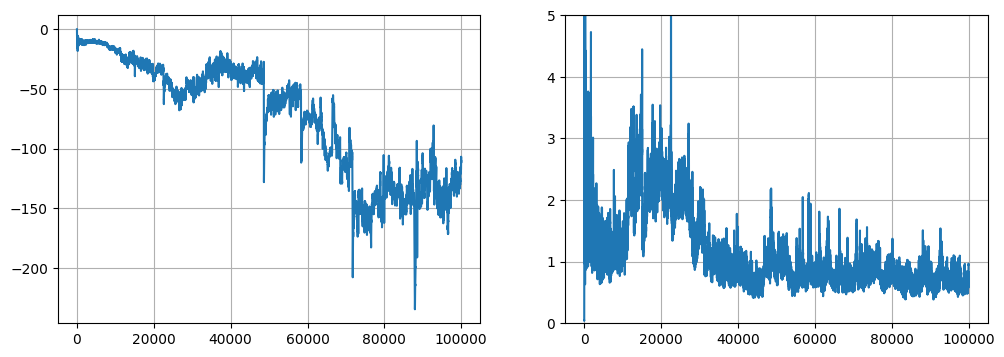

In [43]:
figsize(12,4)
plt.subplot(121)
plt.plot(loss_plot)
plt.grid()
plt.subplot(122)
plt.plot(gradV_plot)
plt.ylim(0.0, 5.0)
plt.grid()

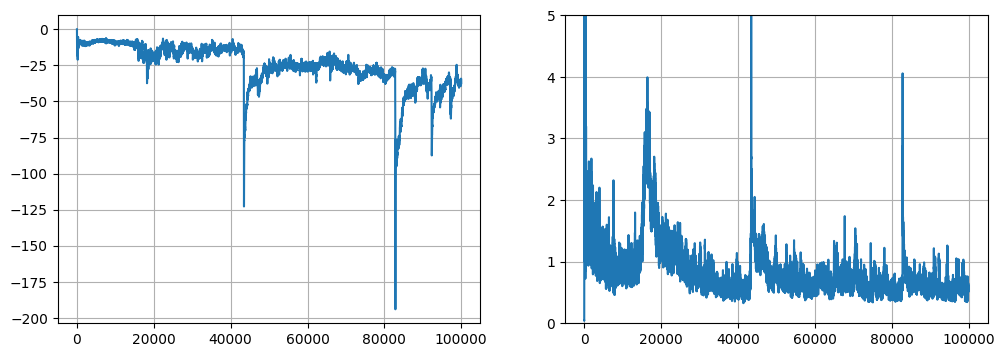

In [ ]:
figsize(12,4)
plt.subplot(121)
plt.plot(loss_plot)
plt.grid()
plt.subplot(122)
plt.plot(gradV_plot)
plt.ylim(0.0, 5.0)
plt.grid()

In [54]:
dt = 1e-2
t = 0.0
n = int(1/dt)
x = np.zeros((BS,n+1,2))
x[:,0,:] = X[0][BS,:]
x_t = np.zeros((BS,n+1,2))
x_t[:,0,:] = X[0][BS,:]
t = np.zeros((BS,n+1,1))
for i in trange(n):
  x[:,i+1,:] = x[:,i,:] + dt*dsdx_fn(t[:,i,:], x[:,i,:], state_s.params)
  t[:,i+1,:] = t[:,i,:] + dt
  x_t[:,i+1,:] = state_q.apply_fn(state_q.params, t[:,i,:], DATA_0, DATA_1)

NameError: name 'DS' is not defined

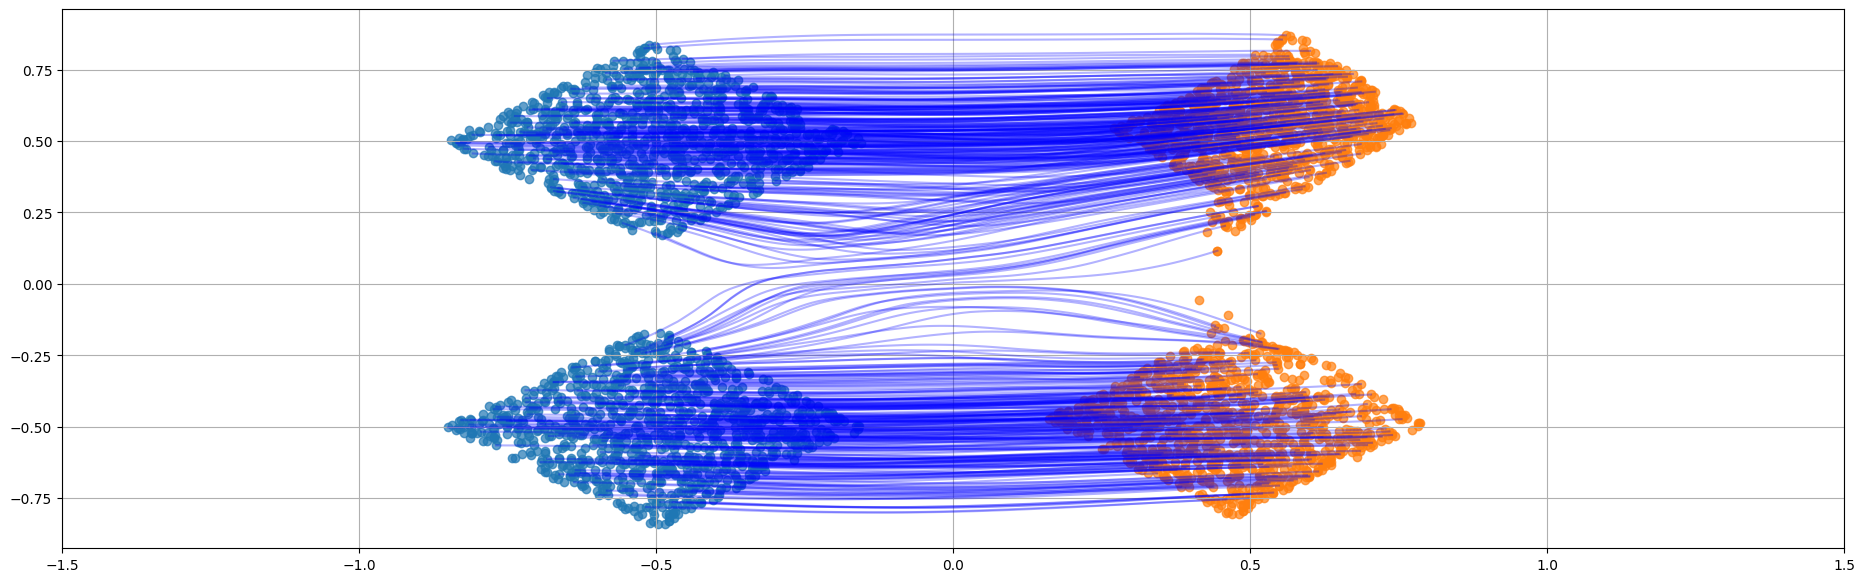

In [ ]:
figsize(23,7)
plt.scatter(DATA_0[:,0], DATA_0[:,1], alpha=0.7)
plt.scatter(x[:,-1,0], x[:,-1,1], alpha=0.7)
for i in range(BS):
  plt.plot(x[i,:,0], x[i,:,1], c='b', alpha=0.3)
plt.xlim(-1.5,1.5)
plt.grid()
plt.show()

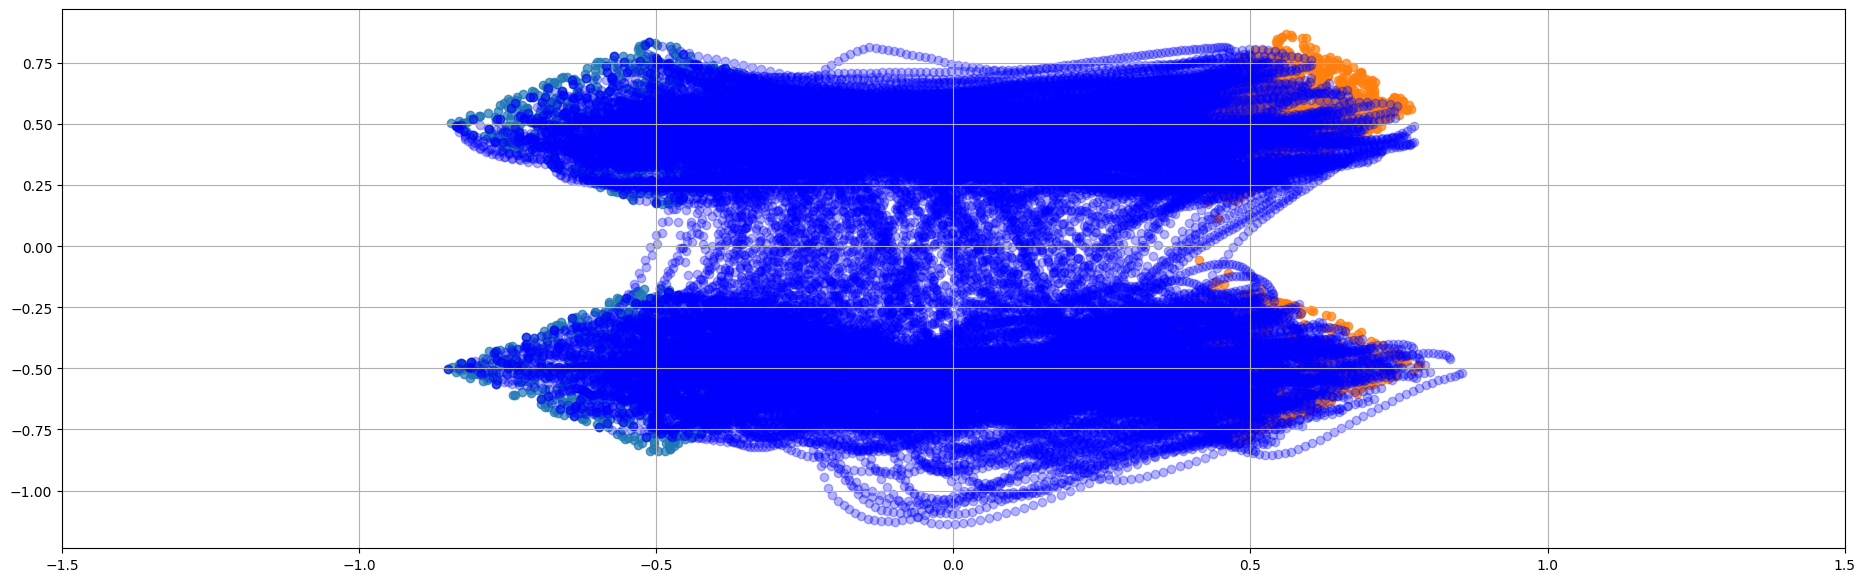

In [ ]:
figsize(23,7)
plt.scatter(DATA_0[:,0], DATA_0[:,1], alpha=0.7)
plt.scatter(x[:,-1,0], x[:,-1,1], alpha=0.7)
for i in range(BS):
  plt.scatter(x_t[i,:,0], x_t[i,:,1], c='b', alpha=0.3)
plt.xlim(-1.5,1.5)
plt.grid()
plt.show()

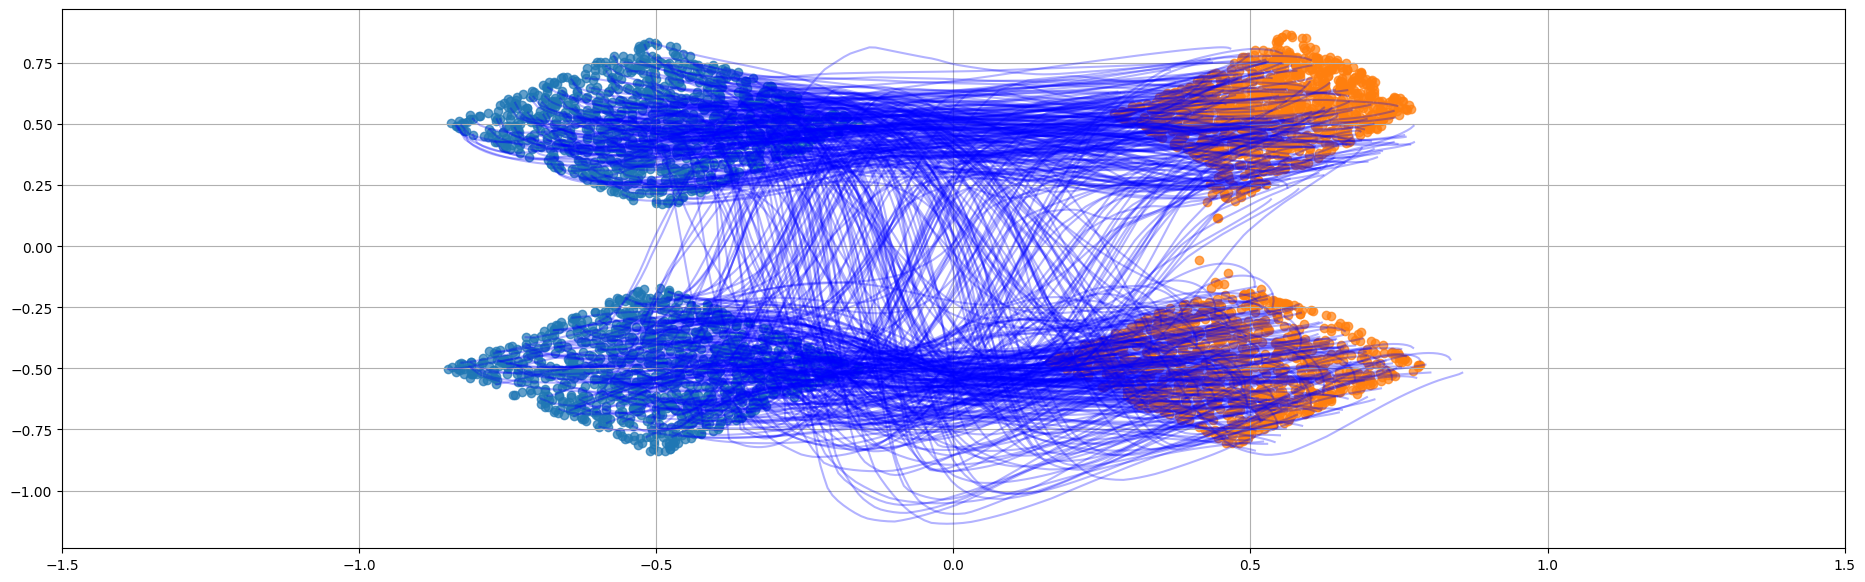

In [ ]:
figsize(23,7)
plt.scatter(DATA_0[:,0], DATA_0[:,1], alpha=0.7)
plt.scatter(x[:,-1,0], x[:,-1,1], alpha=0.7)
for i in range(BS):
  plt.plot(x_t[i,:,0], x_t[i,:,1], c='b', alpha=0.3)
plt.xlim(-1.5,1.5)
plt.grid()
plt.show()

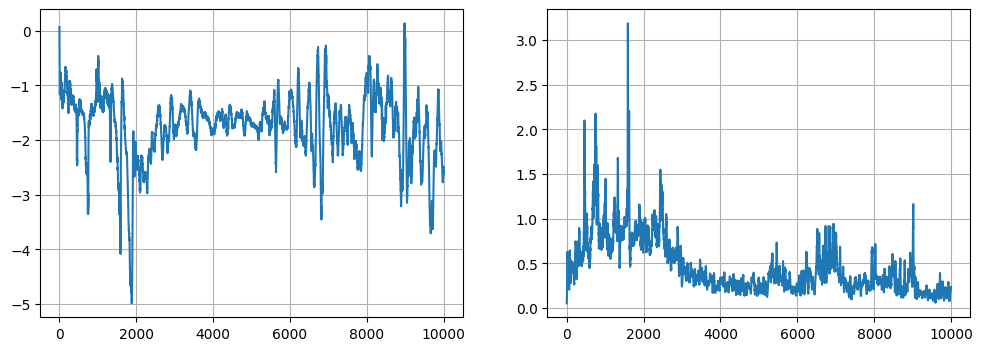

In [ ]:
figsize(12,4)
plt.subplot(121)
plt.plot(loss_plot)
plt.grid()
plt.subplot(122)
plt.plot(gradV_plot)
# plt.ylim(0.0, 5.0)
plt.grid()

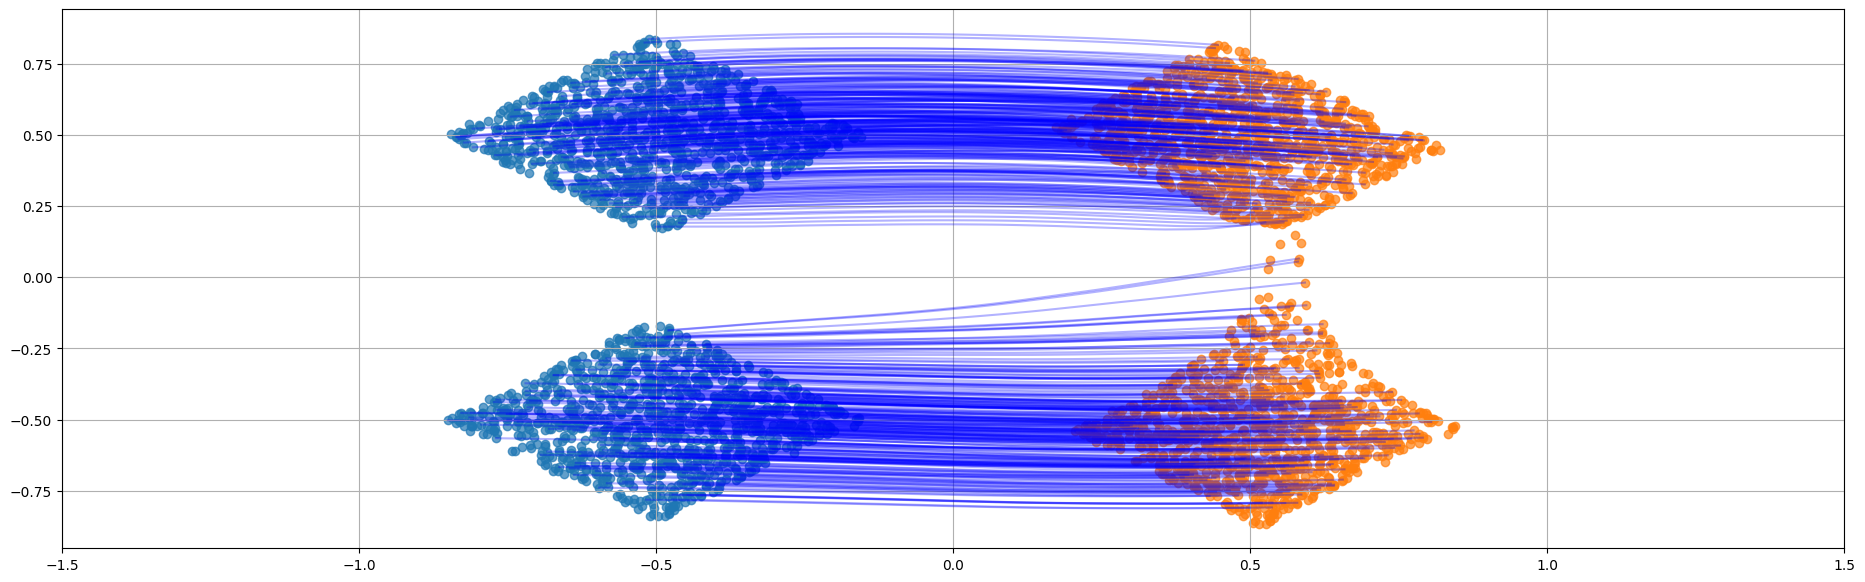

In [ ]:
figsize(23,7)
plt.scatter(DATA_0[:,0], DATA_0[:,1], alpha=0.7)
plt.scatter(x[:,-1,0], x[:,-1,1], alpha=0.7)
for i in range(BS):
  plt.plot(x[i,:,0], x[i,:,1], c='b', alpha=0.3)
plt.xlim(-1.5,1.5)
plt.grid()
plt.show()

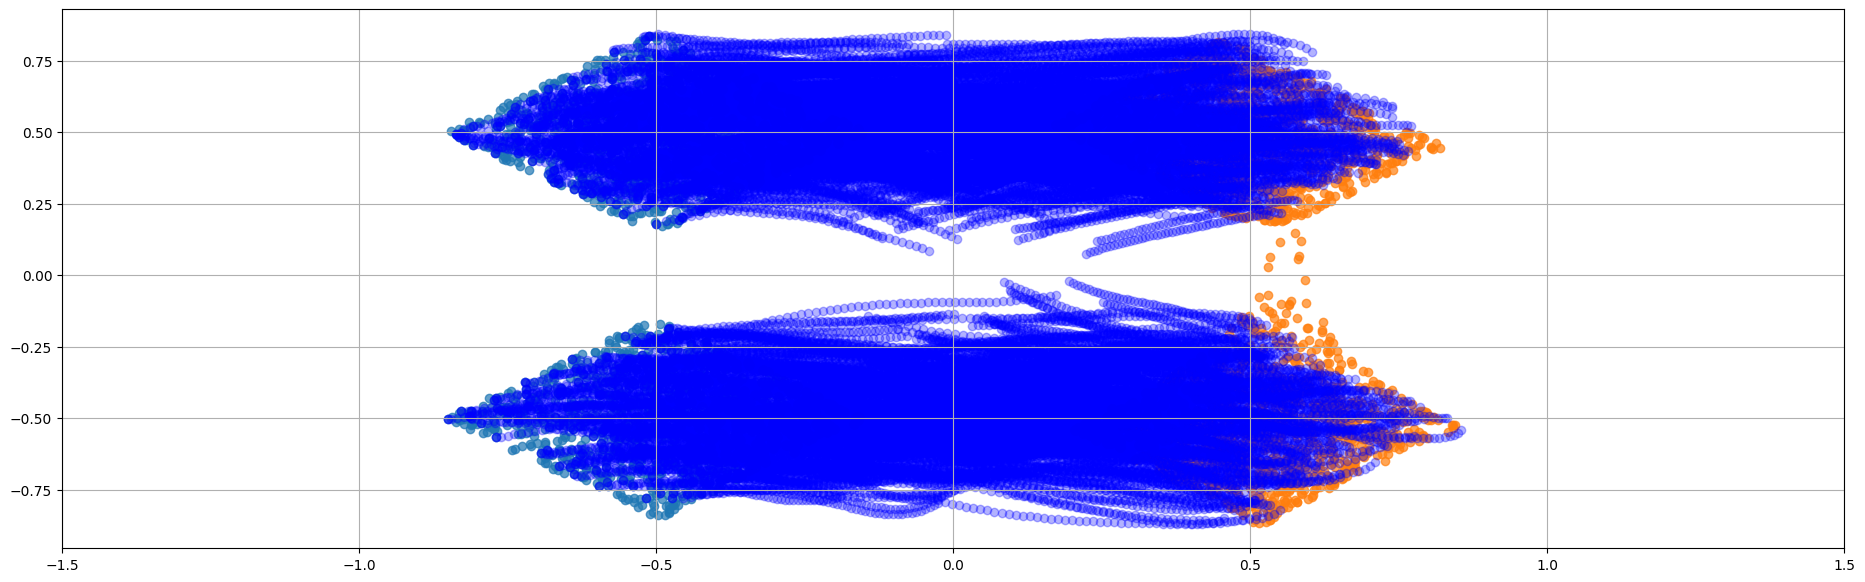

In [ ]:
figsize(23,7)
plt.scatter(DATA_0[:,0], DATA_0[:,1], alpha=0.7)
plt.scatter(x[:,-1,0], x[:,-1,1], alpha=0.7)
for i in range(BS):
  plt.scatter(x_t[i,:,0], x_t[i,:,1], c='b', alpha=0.3)
plt.xlim(-1.5,1.5)
plt.grid()
plt.show()

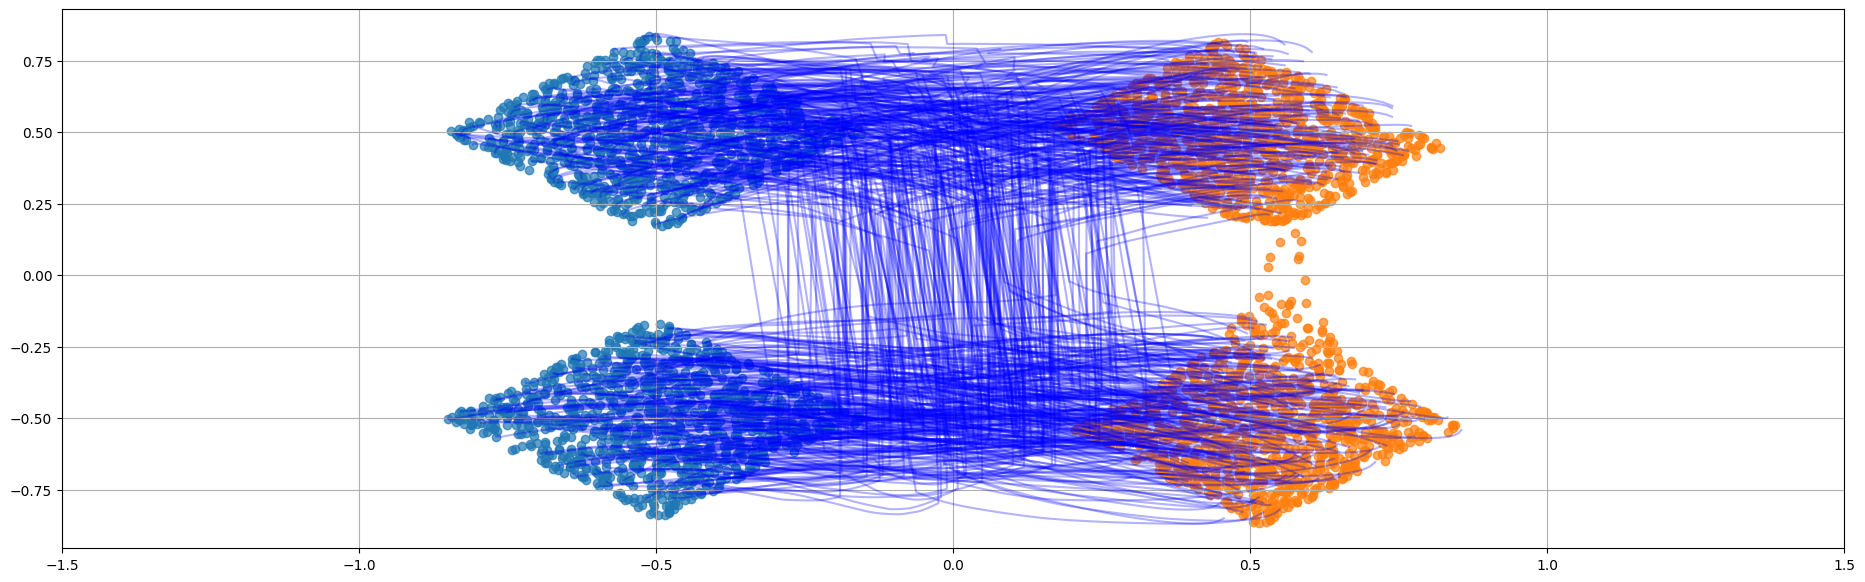

In [ ]:
figsize(23,7)
plt.scatter(DATA_0[:,0], DATA_0[:,1], alpha=0.7)
plt.scatter(x[:,-1,0], x[:,-1,1], alpha=0.7)
for i in range(BS):
  plt.plot(x_t[i,:,0], x_t[i,:,1], c='b', alpha=0.3)
plt.xlim(-1.5,1.5)
plt.grid()
plt.show()